# Define Dependencies

In [1]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Global Variables
windowSize = 5
numPCAcomponents = 30
testRatio = 0.25

In [3]:
print (os.getcwd())

/home/ilab/HyperSpectral/Classification-of-Hyperspectral-Image


# Define the neccesary functions for later use

In [4]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'Data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy


def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch



In [5]:
# X_test = np.load("./Data/XtestWindowSize" 
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRAtio" + str(testRatio) + ".npy")
# y_test = np.load("./Data/ytestWindowSize" 
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


X_test = np.load("./Data/XtestWindowSize5PCA30testRatio0.25.npy" )
y_test = np.load("./Data/ytestWindowSize5PCA30testRatio0.25.npy")

In [6]:
# X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [7]:
# load the model architecture and weights
model = load_model('my_model.h5')

In [9]:
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

2563/2563 [==============================] - 0s 28us/step


In [11]:
# load the original image
X, y = loadIndianPinesData()

In [12]:
X,pca = applyPCA(X,numComponents=numPCAcomponents)

In [13]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

In [17]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = int(y[i+int(PATCH_SIZE/2), j+int(PATCH_SIZE/2)])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            #print (image_patch.shape)
#             X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')    
            X_test_image = image_patch.reshape(1,image_patch.shape[1],image_patch.shape[0],image_patch.shape[2]).astype('float32')                                   

            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+int(PATCH_SIZE/2)][j+int(PATCH_SIZE/2)] = prediction+1

In [18]:
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

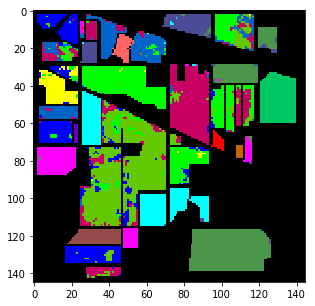

In [19]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))